## Run a `GMM`-`AffineMode` model on the 9-12-removed dataset

In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from kpsn.models.morph import affine_mode as afm 
from kpsn.models.pose import gmm
from kpsn.models import joint_model
from kpsn.fitting import em
from kpsn import models
from kpsn import util
from kpsn.models import pose
from kpsn.util import pca
from kpsn.util import keypt_io
from kpsn.util import alignment

import kpsn_test.visualize as viz
from kpsn_test import util as test_util

import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors as mplcol
import seaborn as sns

import tensorflow_probability.substrates.jax as tfp

import joblib

alll ['affine_mode', 'defaults', 'diagram_plots', 'fitting', 'mixtures', 'morphs', 'struct']


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
from jax import config
config.update("jax_debug_nans", True)

### Load data

In [5]:
metadata, keypts = keypt_io.npy_dataset("/n/groups/datta/kai/mph/data_explore/data/")

# operate on a subset of the data without some redundancy
# since we don't care about dynamics anyway
keypts = keypt_io.subsample_time(keypts, 15)

# rotate subject to standard orientation
align_result = alignment.sagittal_align(keypts)
metadata, align_result = keypt_io.select_subset(metadata, align_result, [
    i_subj for i_subj in range(len(align_result))
    if (not metadata['age'][i_subj] in [9, 12])
])

gt_obs = pose.Observations(
    keypt_io.to_feats(util.computations.restack(align_result))[:, :],
    util.computations.stack_ixs(align_result))

### Set up model

In [11]:
N = len(align_result)
M = gt_obs.keypts.shape[1]
eps = 0.05
morph_hyperparams = afm.AffineModeMorphHyperparams(
    N = N, M = M, L = 1,
    modes=None, update_scale = 0.3)
pose_hyperparams = gmm.GMMHyperparams(
    N = N, M = M, L = 5, eps = eps,
    pop_weight_uniformity = 10,
    subj_weight_uniformity = 100)
model = joint_model.JointModel(morph = afm.AffineModeMorph, posespace = gmm.GMMPoseSpaceModel)
hyperparams = joint_model.JointHyperparams(morph = morph_hyperparams, posespace = pose_hyperparams)

Reloading 'kpsn.util.computations'.


In [7]:
init_params = joint_model.init(
    model,
    hyperparams,
    gt_obs,
    reference_subject = 21,
    posespace_kws = dict(
        fit_to_all_subj = False,
        subsample = 0.1)
).with_hyperparams(hyperparams)
# init_params = init_params.with_morph(afm.with_locked_modes(init_params.morph))

2023-10-25 16:56:24.042752: W external/xla/xla/service/gpu/buffer_comparator.cc:1054] INTERNAL: ptxas exited with non-zero error code 65280, output: ptxas /tmp/tempfile-compute-g-17-161.o2.rc.hms.harvard.edu-d298f421-270083-60890b0274d85, line 10; fatal   : Unsupported .version 7.8; current version is '7.7'
ptxas fatal   : Ptx assembly aborted due to errors

Relying on driver to perform ptx compilation. 
Setting XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda  or modifying $PATH can be used to set the location of ptxas
This message will only be logged once.


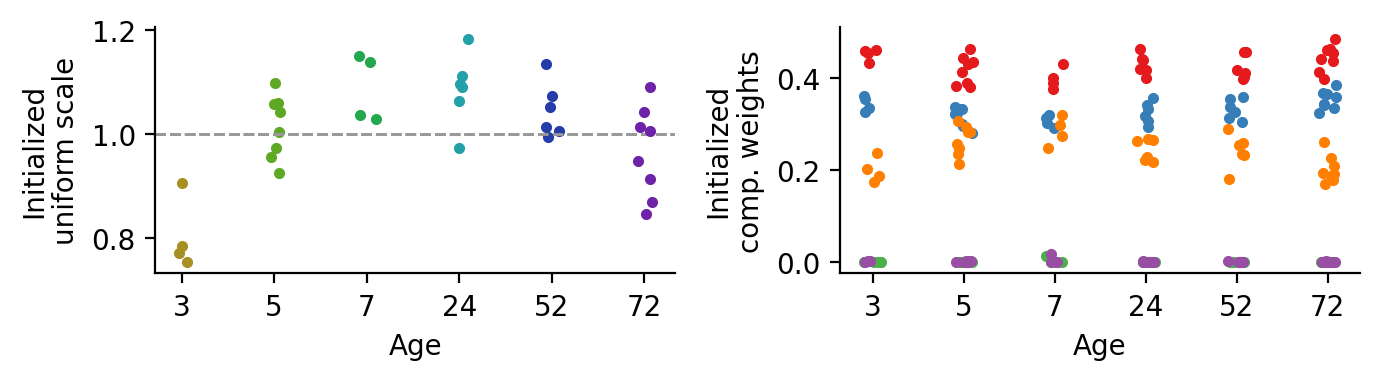

In [37]:
fig, ax = plt.subplots(1, 2, figsize = (7, 2))

jitter = 0.1
ages, age_groups = keypt_io.get_groups(metadata, 'age')
age_pal = dict(zip(ages, sns.hls_palette(l = 0.4, n_colors = len(ages) + 2)[1:-1]))
comp_pal = sns.color_palette('Set1', hyperparams.posespace.L)

for i_age, (age, age_group) in enumerate(zip(ages, age_groups)):
    ax[0].axhline(1, ls = '--', color = '.6', lw = 1)
    ax[0].plot(
        np.random.uniform(-jitter, jitter, len(age_group)) + i_age,
        jnp.exp(init_params.morph.uniform_scale()[age_group]),
        'o', ms = 3, color = age_pal[age])
    for i_comp in range(hyperparams.posespace.L):
        ax[1].plot(
            np.random.uniform(-jitter, jitter, len(age_group)) + i_age,
            init_params.posespace.weights()[age_group, i_comp],
            'o', ms = 3, color = comp_pal[i_comp],
        )

for i in [0,1]: 
    ax[i].set_xticks(np.arange(len(ages)))
    ax[i].set_xticklabels(ages)
    ax[i].set_xlabel("Age")
ax[0].set_ylabel("Initialized\nuniform scale")
ax[1].set_ylabel("Initialized\ncomp. weights")
sns.despine()
plt.tight_layout()
plt.show()

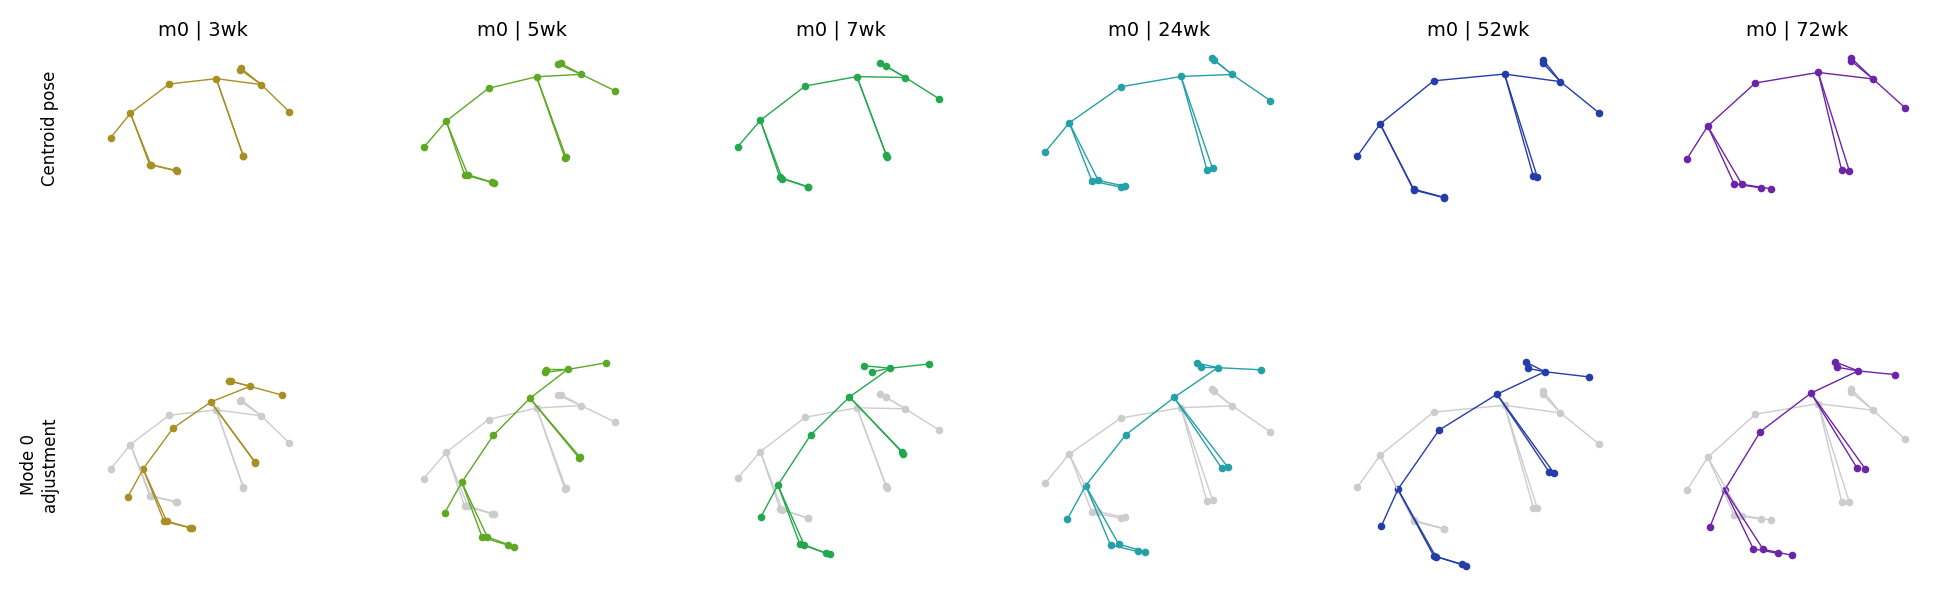

In [34]:
init_all_poses = model.morph.pose_mle(gt_obs, init_params.morph)

plot_subset = [age_group[0] for age_group in age_groups]
xaxis, yaxis = 0, 2

viz.affine_mode.mode_body_diagrams(
    init_params.morph,
    viz.affine_mode.mode_quantiles(init_params.morph, init_all_poses, 0.9),
    metadata['age'], metadata['id'],
    xaxis, yaxis, plot_subset, age_pal);

### Fit model

In [12]:
loss_hist, fit_params, mstep_losses, param_hist, trace = em.iterate_em(
    model = model,
    init_params = init_params.params,
    emissions = gt_obs,
    hyperparams = init_params.hyperparams,
    n_steps = 10,
    log_every = -1,
    progress = True,
    tol = None,
    batch_size = 30,
    mstep_n_steps = 150,
    mstep_learning_rate = 7e-3,
    mstep_tol = 1e-3,
    mstep_stop_window = 25,
    return_mstep_losses = True,
    return_param_hist = True,
    return_reports = True
)

  0%|          | 0/10 [00:00<?, ?it/s]

using d
using d
using d


 10%|█         | 1/10 [00:06<01:01,  6.82s/it]

using d


 20%|██        | 2/10 [00:08<00:29,  3.64s/it]

using d


 30%|███       | 3/10 [00:09<00:18,  2.63s/it]

using d


 40%|████      | 4/10 [00:11<00:12,  2.15s/it]

using d


 50%|█████     | 5/10 [00:12<00:09,  1.88s/it]

using d


 60%|██████    | 6/10 [00:13<00:06,  1.71s/it]

using d


 70%|███████   | 7/10 [00:15<00:04,  1.61s/it]

using d


 80%|████████  | 8/10 [00:16<00:03,  1.56s/it]

using d


 90%|█████████ | 9/10 [00:18<00:01,  1.51s/it]

using d


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


In [9]:
with test_util.load_or_fit(
    '/n/groups/datta/kai/mph/data_explore/models/default/training.jl',
    force_refit = False) as jldata:

    if jldata.exists():
        loss_hist, fit_params, mstep_losses, param_hist, trace  = jldata.get(
            'loss_hist', 'fit_params', 'mstep_losses', 'param_hist', 'trace')
    else:
        print(f"Saving training trace")
        jldata.save(
            loss_hist = loss_hist, fit_params = fit_params, mstep_losses = mstep_losses, param_hist = param_hist, trace = trace)

Loading from /n/groups/datta/kai/mph/data_explore/models/default/training.jl


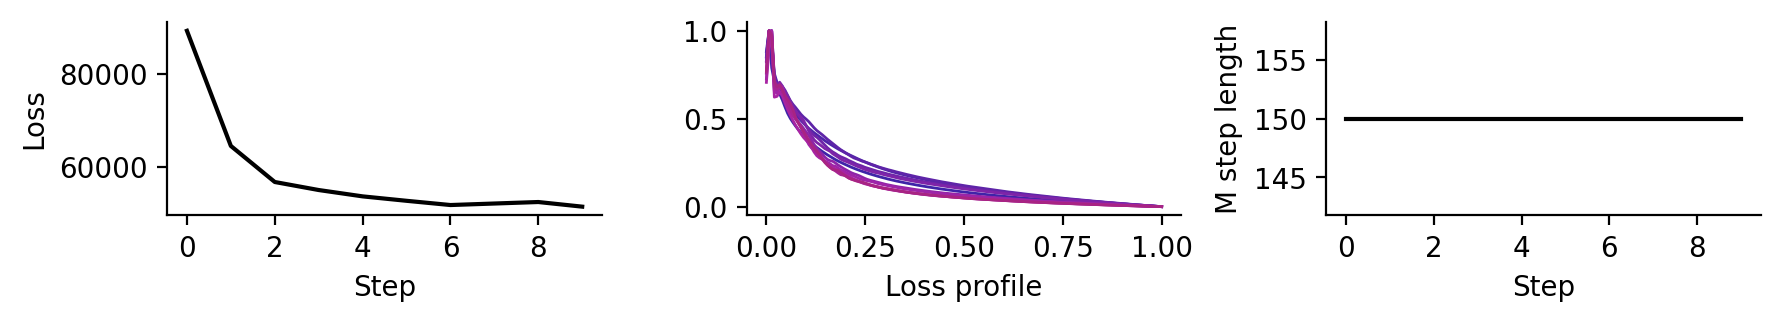

In [9]:
fig, ax = plt.subplots(figsize = (9, 1.7), ncols = 3)
ax[0].plot(loss_hist, 'k-')
pal = sns.hls_palette(len(mstep_losses) * 5, h = 0.7, l = 0.4)[:len(mstep_losses)]
lw = np.linspace(1, 1, len(mstep_losses))
mstep_lengths = []
for i in range(0, len(mstep_losses)):
    if np.any(~np.isfinite(mstep_losses[i])):
        curr_loss = mstep_losses[i][:np.argmax(~np.isfinite(mstep_losses[i]))]
        if len(curr_loss) == 0: continue
    else:
        curr_loss = mstep_losses[i]
    mstep_lengths.append(len(curr_loss))
    ax[1].plot(
        np.linspace(0, 1, len(curr_loss)),
        (curr_loss - curr_loss.min()) / (curr_loss.max() - curr_loss.min()),
        color = pal[i], lw = lw[i])
ax[2].plot(np.arange(len(mstep_lengths)), mstep_lengths, 'k-')
ax[1].set_xlabel("Loss profile")
ax[2].set_ylabel("M step length")
ax[2].set_xlabel("Step")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Step")
plt.tight_layout()
sns.despine()

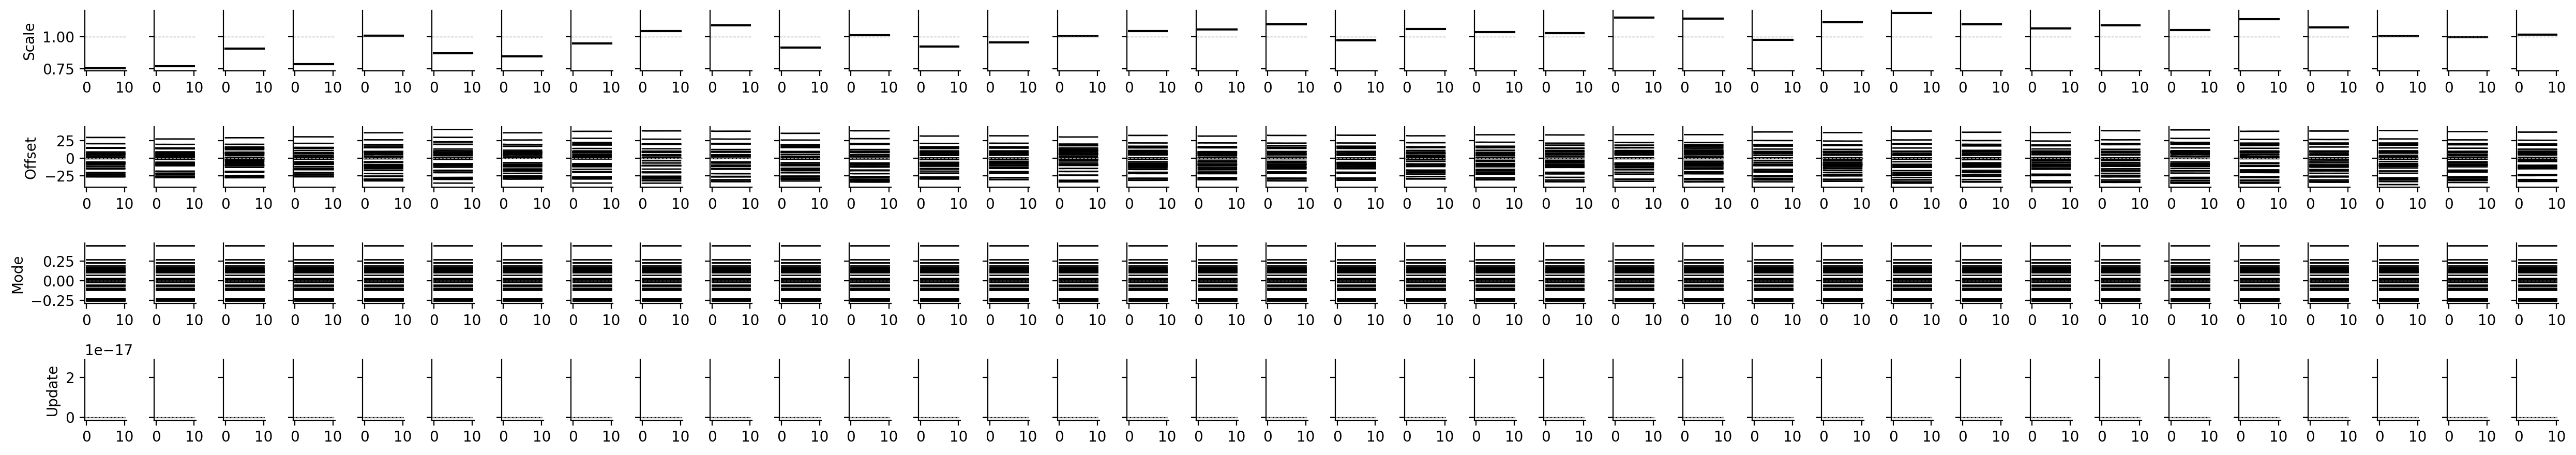

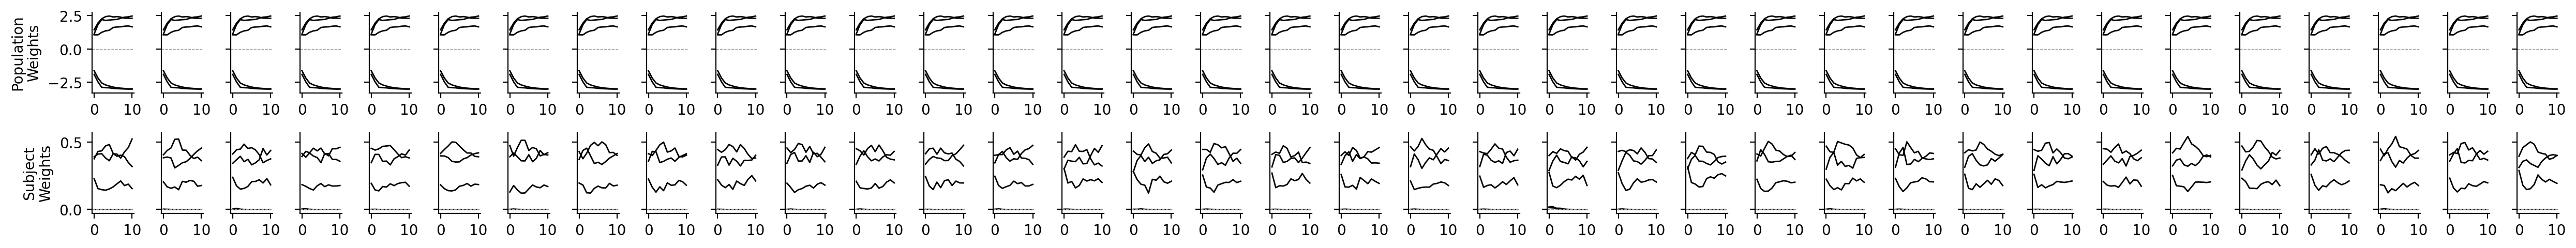

In [10]:
scale_hist = np.stack([p.morph.uniform_scale() for p in param_hist])
ofs_hist = np.stack([p.morph.offsets() for p in param_hist])
mode_hist = np.stack([p.morph.modes() for p in param_hist])
update_hist = np.stack([p.morph.updates() for p in param_hist])

pop_weight_hist = np.stack([p.posespace.pop_logits() for p in param_hist])
subj_weight_hist = np.stack([p.posespace.weights() for p in param_hist])

fig, ax = plt.subplots(4, hyperparams.morph.N, figsize = (25, 4.5), sharey = 'row')
for subj_i in range(hyperparams.morph.N):
    ax[0, subj_i].plot(np.exp(scale_hist[:, subj_i]), 'k-')
    ax[0, subj_i].axhline(1, ls = '--', color = '.6', lw = 0.5)
    ax[1, subj_i].plot(ofs_hist[:, subj_i], 'k-', lw = 1)
    ax[2, subj_i].plot(mode_hist[:, :, 0], 'k-', lw = 1)
    ax[3, subj_i].plot(jnp.linalg.norm(update_hist[:, subj_i, :, 0], axis=1), 'k-', lw = 1)
    for i in [1, 2, 3]:
        ax[i, subj_i].axhline(0, ls = '--', color = '.6', lw = 0.5)
ax[0, 0].set_ylabel("Scale")
ax[1, 0].set_ylabel("Offset")
ax[2, 0].set_ylabel("Mode")
ax[3, 0].set_ylabel("Update")
sns.despine()
plt.tight_layout()


fig, ax = plt.subplots(2, hyperparams.morph.N, figsize = (25, 2.5), sharey = 'row')
for subj_i in range(hyperparams.morph.N):
    ax[0, subj_i].plot(pop_weight_hist, 'k-', lw = 1)
    ax[1, subj_i].plot(subj_weight_hist[:, subj_i], 'k-', lw = 1)
    for i in [0, 1]:
        ax[i, subj_i].axhline(0, ls = '--', color = '.6', lw = 0.5)
ax[0, 0].set_ylabel("Population\nWeights")
ax[1, 0].set_ylabel("Subject\nWeights")
sns.despine()
plt.tight_layout()

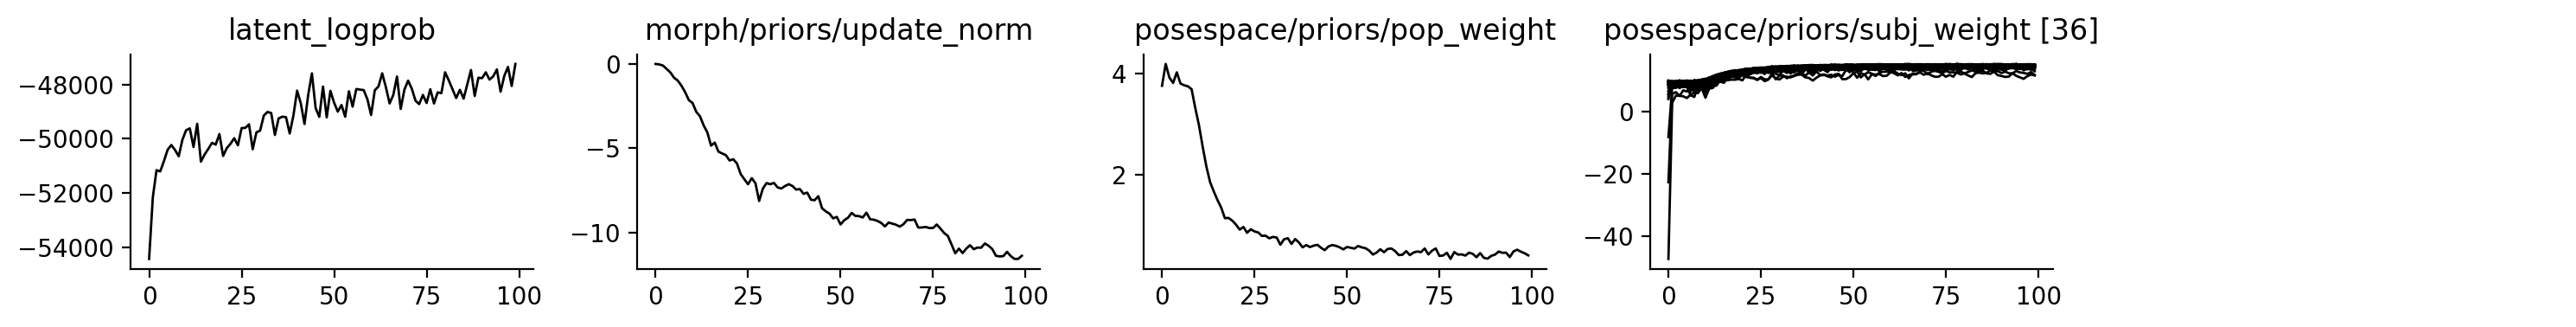

In [110]:
n_col = 5
n_row = int(np.ceil(trace.n_leaves() / n_col))
fig, ax = plt.subplots(n_row, n_col, figsize = (3 * n_col, 2 * n_row))
trace.plot(ax.ravel()[:trace.n_leaves()], color = 'k', lw = 1)
for a in ax.ravel()[trace.n_leaves():]: a.set_axis_off()
sns.despine()
plt.tight_layout()

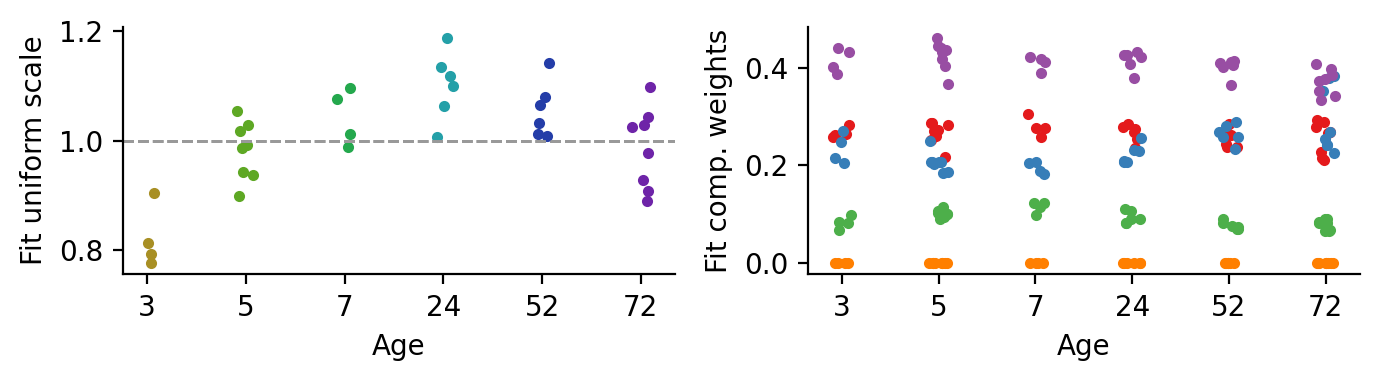

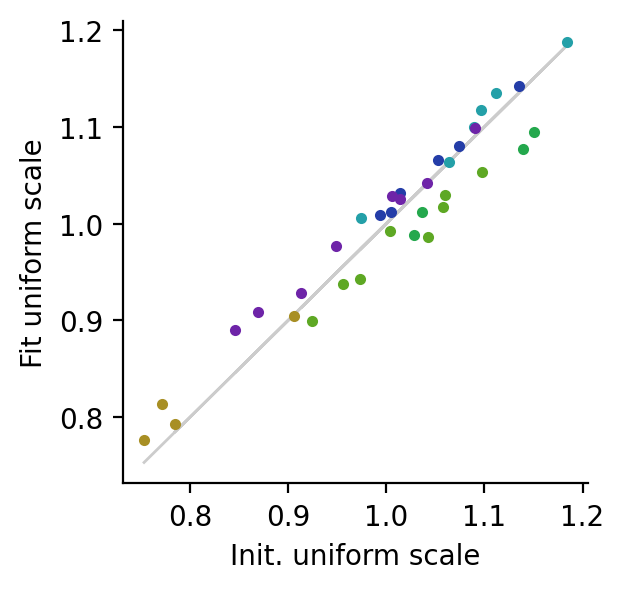

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (7, 2))

jitter = 0.1
ages, age_groups = keypt_io.get_groups(metadata, 'age')
age_pal = dict(zip(ages, sns.hls_palette(l = 0.4, n_colors = len(ages) + 2)[1:-1]))
comp_pal = sns.color_palette('Set1', hyperparams.posespace.L)

for i_age, (age, age_group) in enumerate(zip(ages, age_groups)):
    ax[0].axhline(1, ls = '--', color = '.6', lw = 1)
    ax[0].plot(
        np.random.uniform(-jitter, jitter, len(age_group)) + i_age,
        jnp.exp(fit_params.morph.uniform_scale()[age_group]),
        'o', ms = 3, color = age_pal[age])
    for i_comp in range(hyperparams.posespace.L):
        ax[1].plot(
            np.random.uniform(-jitter, jitter, len(age_group)) + i_age,
            fit_params.posespace.weights()[age_group, i_comp],
            'o', ms = 3, color = comp_pal[i_comp],
        )

for i in [0,1]: 
    ax[i].set_xticks(np.arange(len(ages)))
    ax[i].set_xticklabels(ages)
    ax[i].set_xlabel("Age")
ax[0].set_ylabel("Fit uniform scale")
ax[1].set_ylabel("Fit comp. weights")
sns.despine()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (3, 3))
for i_age, (age, age_group) in enumerate(zip(ages, age_groups)):
    init_scale = jnp.exp(init_params.morph.uniform_scale()[age_group])
    fit_scale = jnp.exp(fit_params.morph.uniform_scale()[age_group])
    ax.plot(init_scale, fit_scale, 'o', ms = 3, color = age_pal[age], zorder = 1)
    ax.plot(init_scale, init_scale, '-', lw = 1, color = '.8', zorder = 0)
    ax.plot()
ax.set_ylabel("Fit uniform scale")
ax.set_xlabel("Init. uniform scale")
sns.despine()
plt.show()


### Visualizations

In [30]:
all_poses = model.morph.pose_mle(
    gt_obs, fit_params.morph) # (Nt, M)

In [35]:
# Components and population distribution
pc_subsample = 10

kp_pcs = pca.fit_with_center(gt_obs.keypts[::pc_subsample])
kp_coords = kp_pcs.whitened_coords(gt_obs.keypts)
kp_coords_by_vid = gt_obs.unstack(kp_coords)

pose_pcs = pca.fit(all_poses)
pose_coords = pose_pcs.whitened_coords(all_poses)
pose_coords_by_vid = gt_obs.unstack(pose_coords)


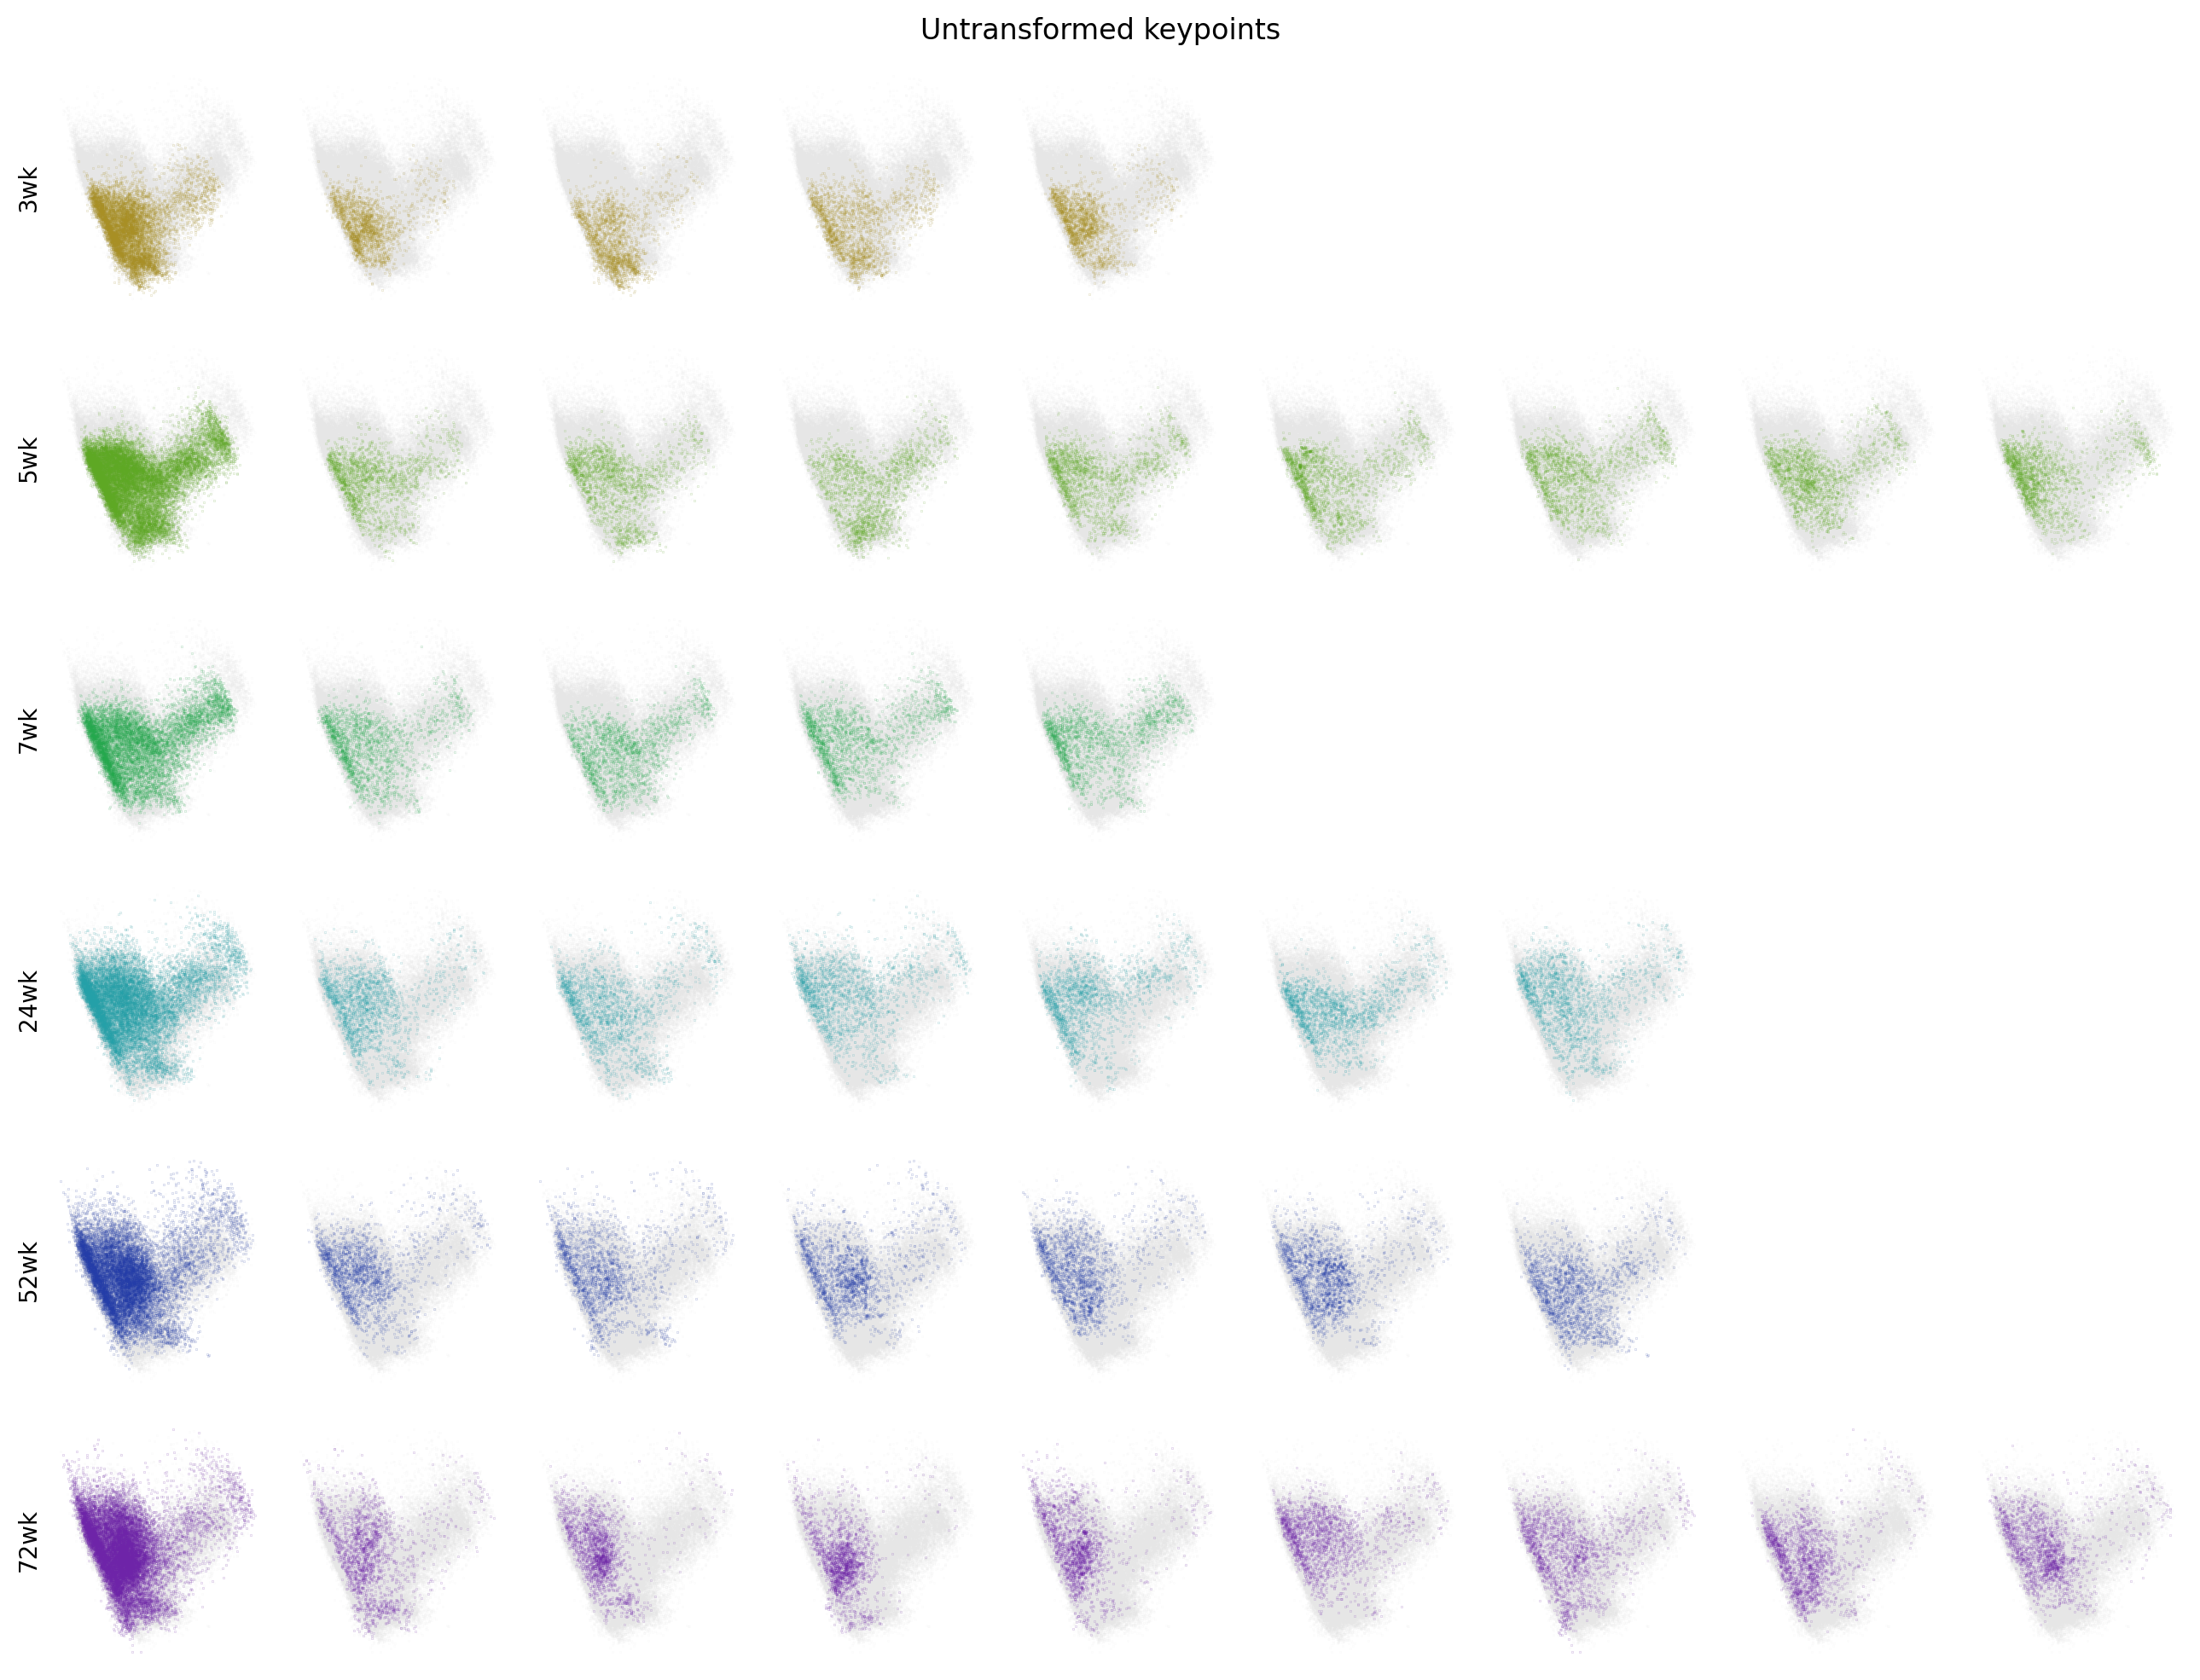

In [36]:
xaxis, yaxis = 0, 1

fig, axes, ax_iter, summ_col_iter = viz.struct.axes_by_age_and_id(
    metadata['age'], metadata['id'],
    summative_col = True,
    figsize = (13, 10))

for ax, age, vids in summ_col_iter():
    ax.scatter(
        kp_coords[:, xaxis], kp_coords[:, yaxis],
        s = 0.005, marker = '.', color = '.9', rasterized = True)
    ax.set_ylabel(f"{age}wk")
    
for ax, age, mouse_id, vid_id, summ_ax in ax_iter():
    ax.scatter(
        kp_coords[:, xaxis], kp_coords[:, yaxis],
        s = 0.005, marker = '.', color = '.9', rasterized = True)
    
    for a in [ax, summ_ax]:
        a.scatter(
            kp_coords_by_vid[vid_id][:, xaxis], kp_coords_by_vid[vid_id][:, yaxis],
            s = 0.01, marker = '.', color = age_pal[age], rasterized = True)

fig.suptitle("Untransformed keypoints")
fig.tight_layout()


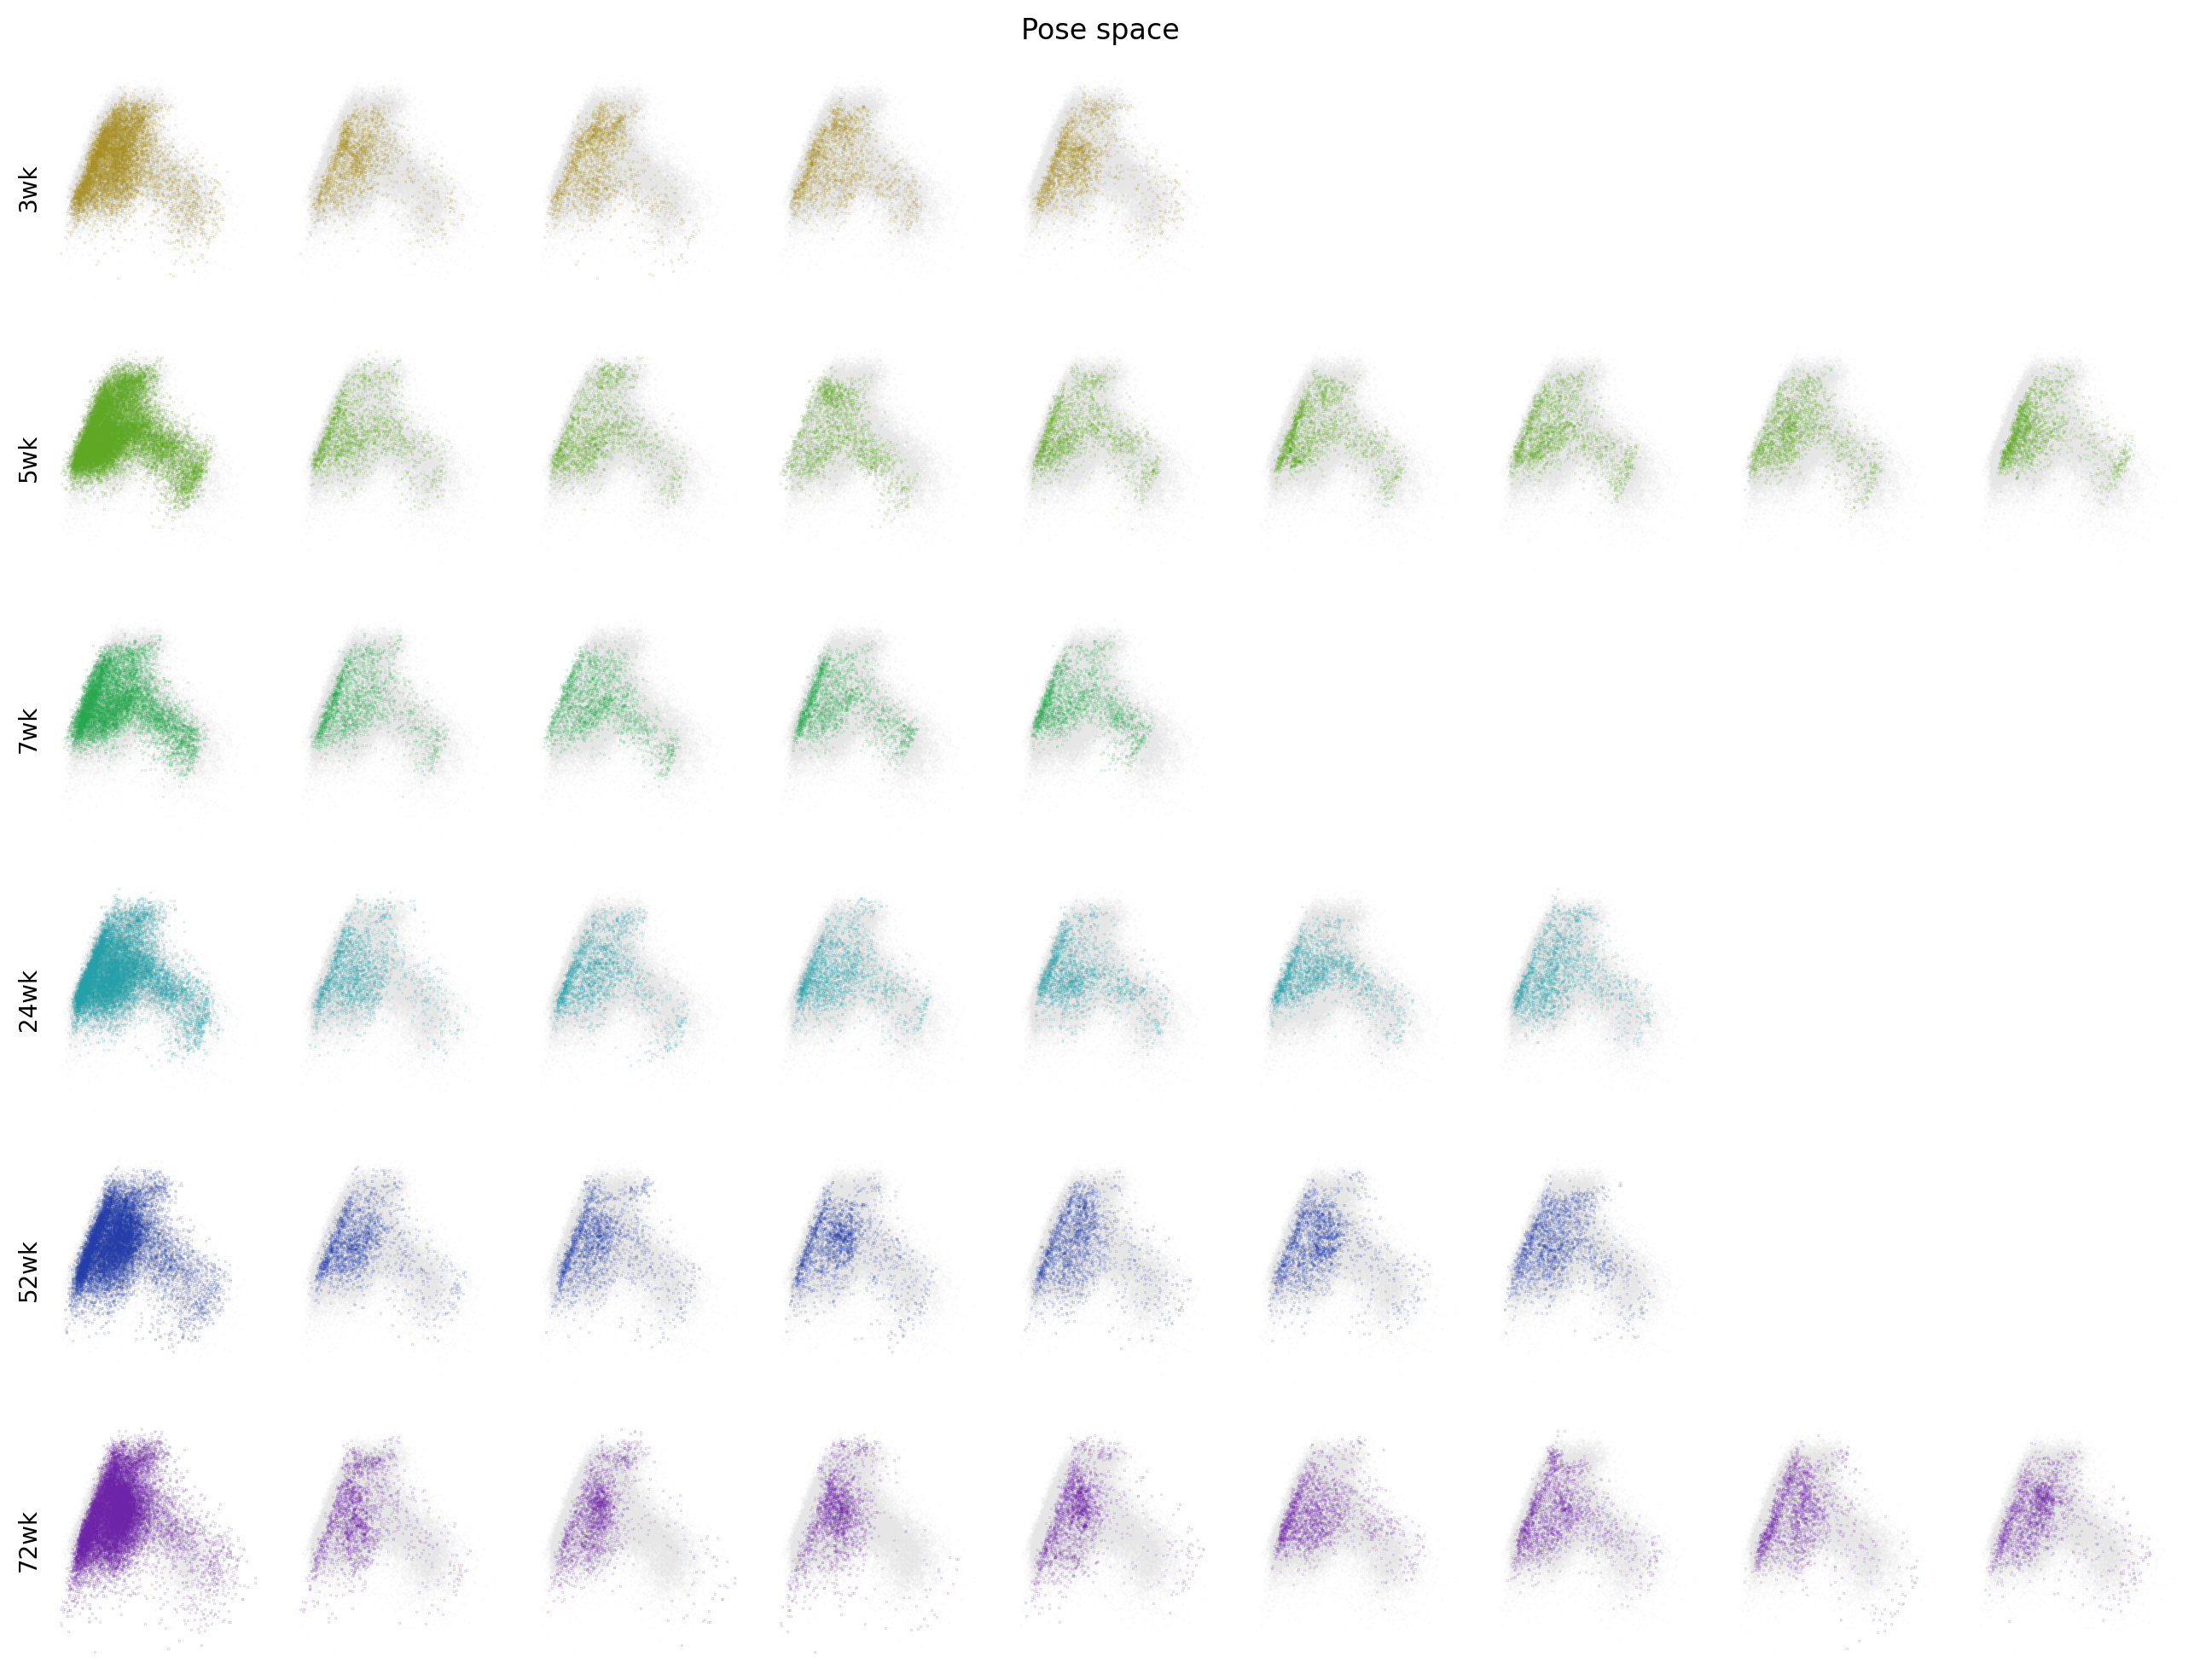

In [37]:
xaxis, yaxis = 0, 1

fig, axes, ax_iter, summ_col_iter = viz.struct.axes_by_age_and_id(
    metadata['age'], metadata['id'],
    summative_col = True,
    figsize = (13, 10))

for ax, age, vids in summ_col_iter():
    ax.scatter(
        pose_coords[:, xaxis], pose_coords[:, yaxis],
        s = 0.005, marker = '.', color = '.9', rasterized = True)
    ax.set_ylabel(f"{age}wk")
    
for ax, age, mouse_id, vid_id, summ_ax in ax_iter():
    ax.scatter(
        pose_coords[:, xaxis], pose_coords[:, yaxis],
        s = 0.005, marker = '.', color = '.9', rasterized = True)
    
    for a in [ax, summ_ax]:
        a.scatter(
            pose_coords_by_vid[vid_id][:, xaxis], pose_coords_by_vid[vid_id][:, yaxis],
            s = 0.01, marker = '.', color = age_pal[age], rasterized = True)

fig.suptitle("Pose space")
fig.tight_layout()

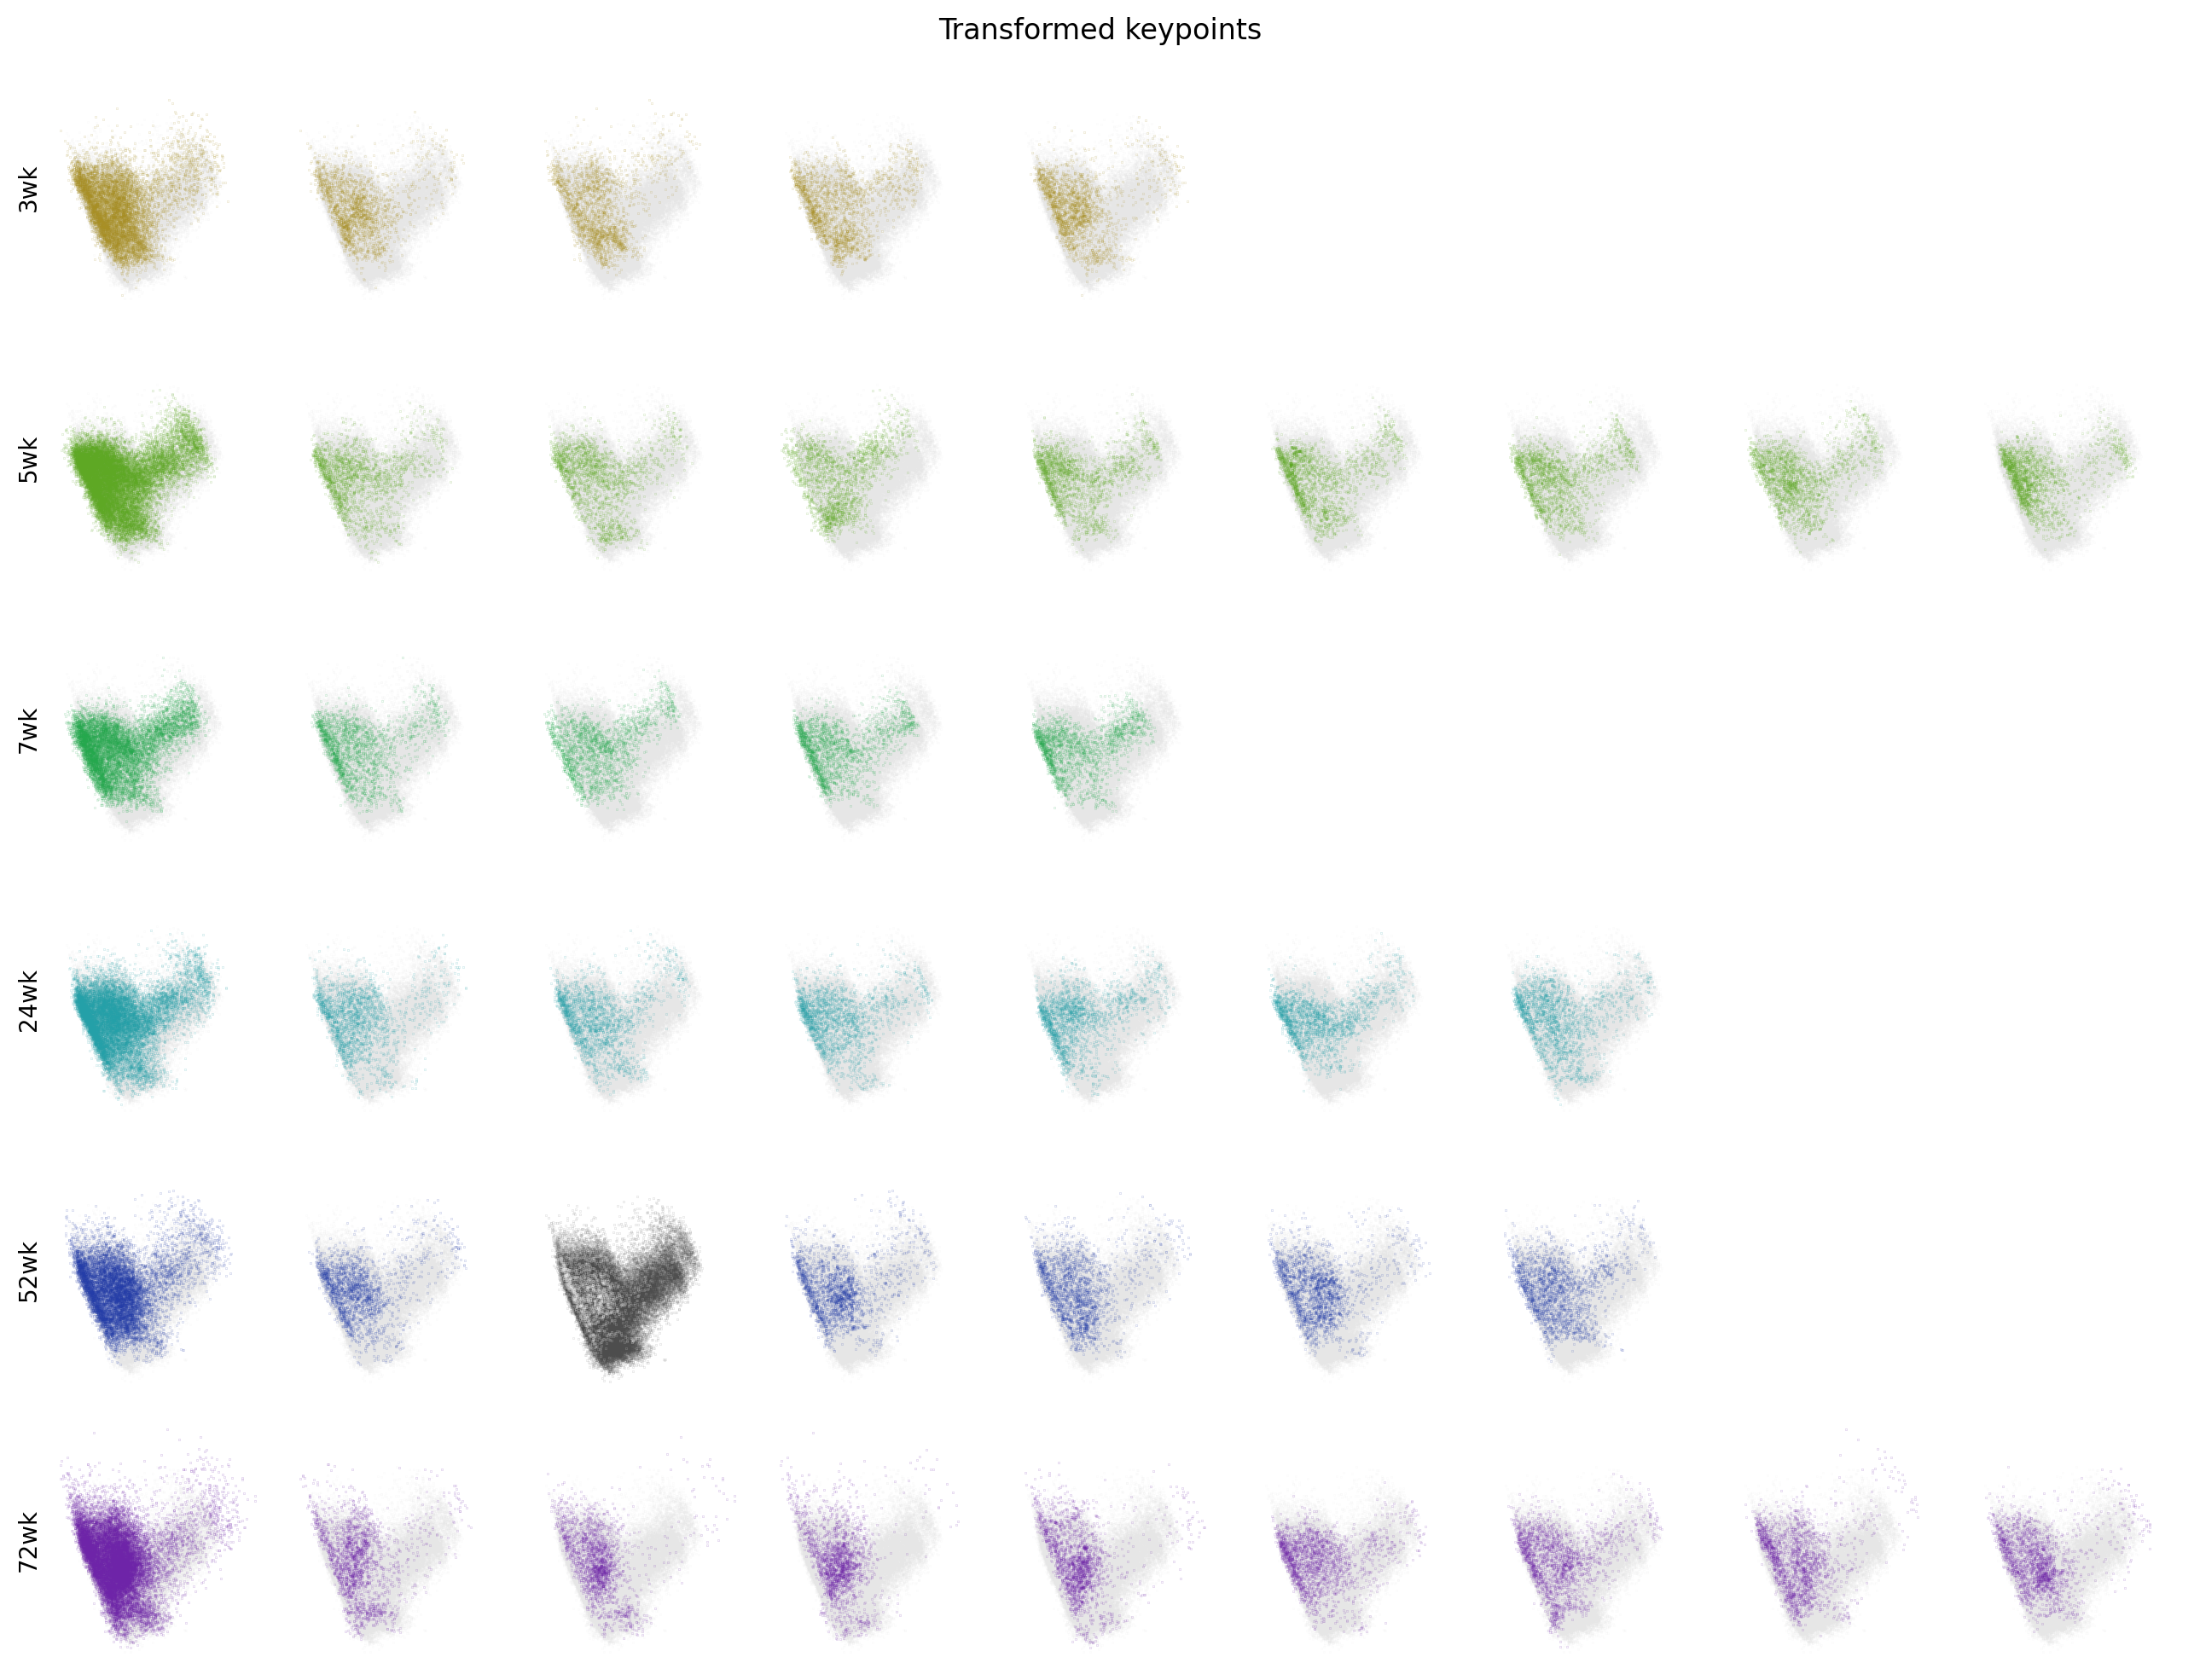

In [41]:
reference_subj = 31
xaxis, yaxis = 0, 1
converted_kps = model.morph.transform(
    fit_params.morph,
    all_poses, jnp.full([len(all_poses)], reference_subj)
)
converted_coords = kp_pcs.whitened_coords(converted_kps)
converted_coords_by_vid = gt_obs.unstack(converted_coords)

fig, axes, ax_iter, summ_col_iter = viz.struct.axes_by_age_and_id(
    metadata['age'], metadata['id'],
    summative_col = True,
    figsize = (13, 10))

for ax, age, vids in summ_col_iter():
    ax.scatter(
        kp_coords[:, xaxis], kp_coords[:, yaxis],
        s = 0.005, marker = '.', color = '.9', rasterized = True)
    ax.set_ylabel(f"{age}wk")
    
for ax, age, mouse_id, vid_id, summ_ax in ax_iter():
    bg_col = '.3' if vid_id == reference_subj else '.9'
    fg_col = 'w' if vid_id == reference_subj else age_pal[age]
    ax.scatter(
        kp_coords[:, xaxis], kp_coords[:, yaxis],
        s = 0.005, marker = '.', color = bg_col, rasterized = True)
    
    for a in [ax, summ_ax]:
        a.scatter(
            converted_coords_by_vid[vid_id][:, xaxis], converted_coords_by_vid[vid_id][:, yaxis],
            s = 0.01, marker = '.', color = fg_col, rasterized = True)

fig.suptitle("Transformed keypoints")
fig.tight_layout()

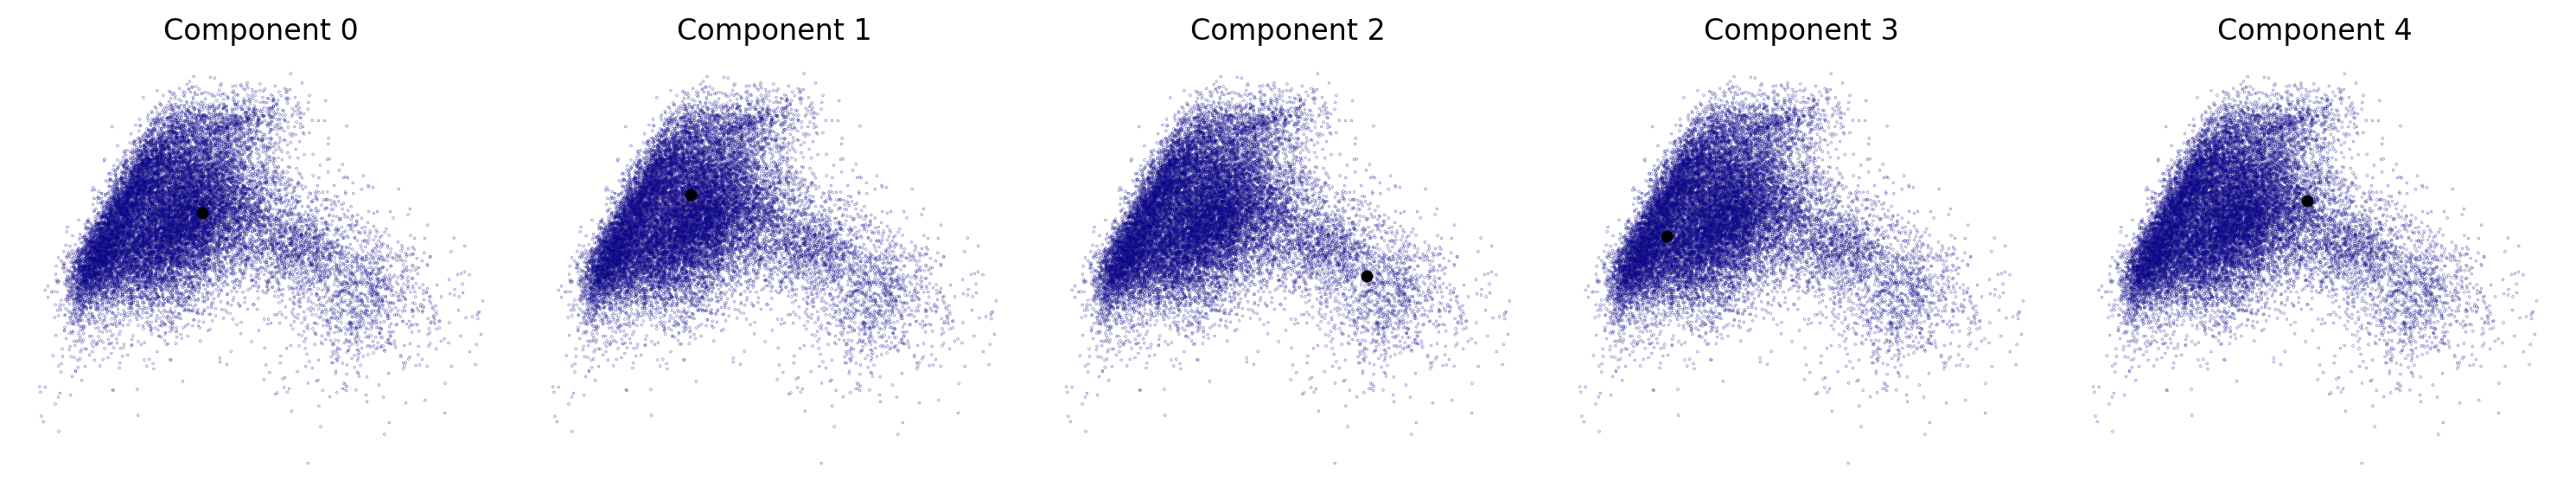

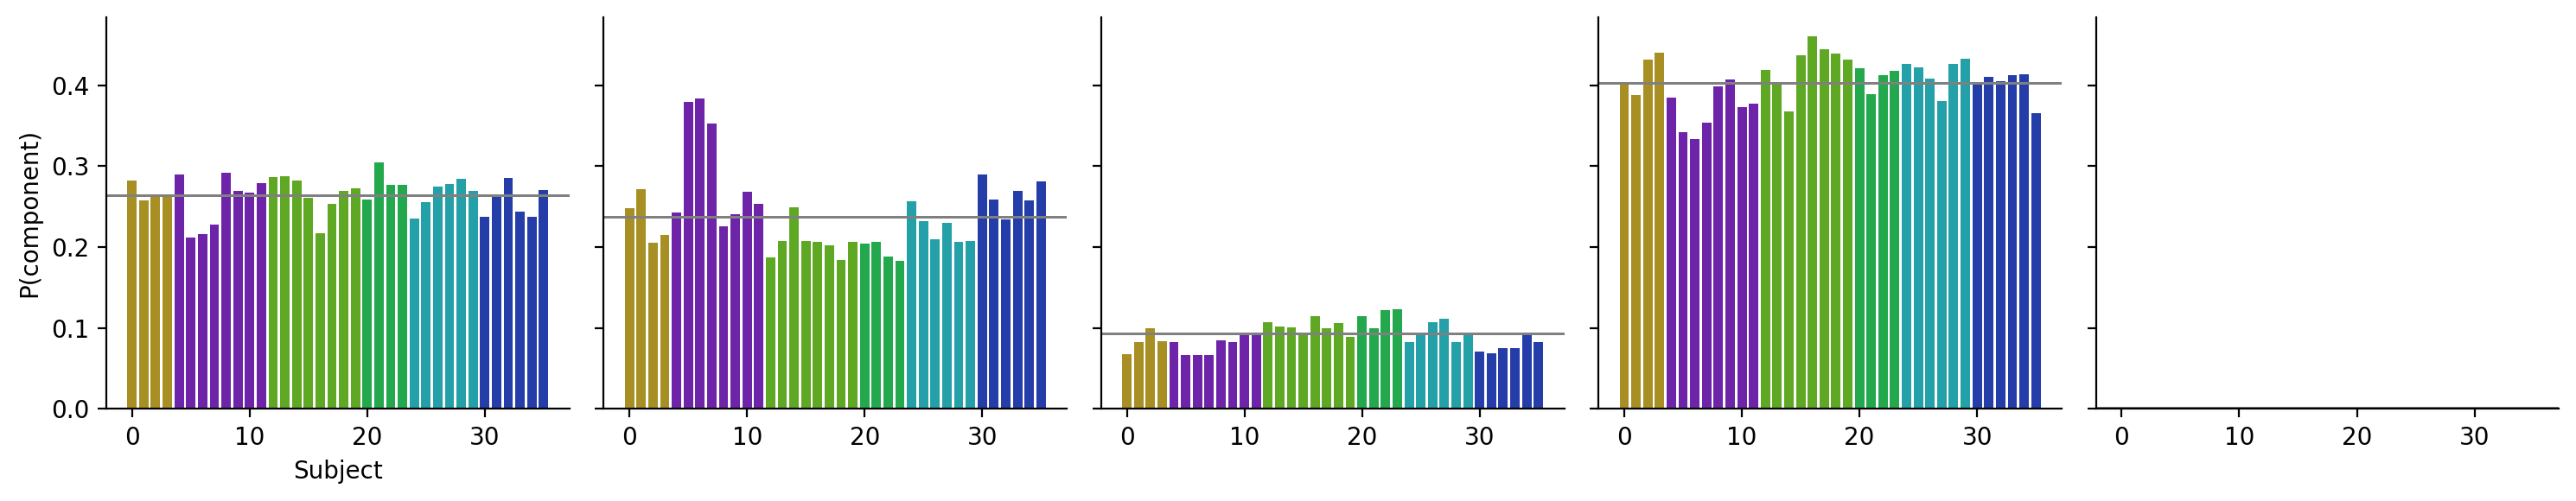

In [65]:
xaxis, yaxis = 0, 1

fig, ax = plt.subplots(1, hyperparams.posespace.L, 
    sharex = True, sharey = True,
    figsize = (hyperparams.posespace.L * 3, 3))

component_logprob = tfp.distributions.MultivariateNormalFullCovariance(
    loc = fit_params.posespace.means[:, None],
    covariance_matrix = fit_params.posespace.covariances()[:, None],).log_prob(
        all_poses[None, ::4])
mean_coords = pose_pcs.whitened_coords(fit_params.posespace.means)
for i_comp in range(hyperparams.posespace.L):
    ax[i_comp].scatter(
        pose_coords[::4, xaxis], pose_coords[::4, yaxis],
        c = component_logprob[i_comp], cmap = 'plasma',
        s = 0.05, marker = '.', rasterized = True)
    
    ax[i_comp].plot(
        [mean_coords[i_comp, xaxis]], [mean_coords[i_comp, yaxis]],
        'ko', ms = 4)
    
    ax[i_comp].set_title(f"Component {i_comp}")
    ax[i_comp].set_xticks([])
    ax[i_comp].set_yticks([])

sns.despine(left = True, bottom = True)
fig.tight_layout()
plt.show()


fig, ax = plt.subplots(1, hyperparams.posespace.L, 
    sharey = True,
    figsize = (hyperparams.posespace.L * 3, 3))
weights = fit_params.posespace.weights()
pop_weights = fit_params.posespace.pop_weights()
for i_comp in range(hyperparams.posespace.L):
    for age, age_group in zip(ages, age_groups):
        ax[i_comp].bar(
            age_group, weights[age_group, i_comp],
            width = 0.8, color = age_pal[age])
        ax[i_comp].axhline(
            pop_weights[i_comp], color = '.5', lw = 1)
ax[0].set_ylabel("P(component)")
ax[0].set_xlabel("Subject")

sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
# Calculate in-sample poses for each morph direction
coords, components, complement = afm.mode_components(
    fit_params.morph, all_poses)
mode_display = fit_params.morph.modes() * jnp.quantile(coords, 0.9, axis = 0)[None] # (M, L)

In [47]:
age_diagram_kws = {
    age: dict(
        scatter_kw = dict(color = age_pal[age]),
        line_kw = dict(linestyle='-', color = age_pal[age], lw = 0.5))
    for age in ages}
ref_diagram_kws = dict(
    scatter_kw = dict(color = '.8'),
    line_kw = dict(linestyle='-', color = '.8', lw = 0.5))

Reloading 'kpsn_test.visualize.affine_mode'.


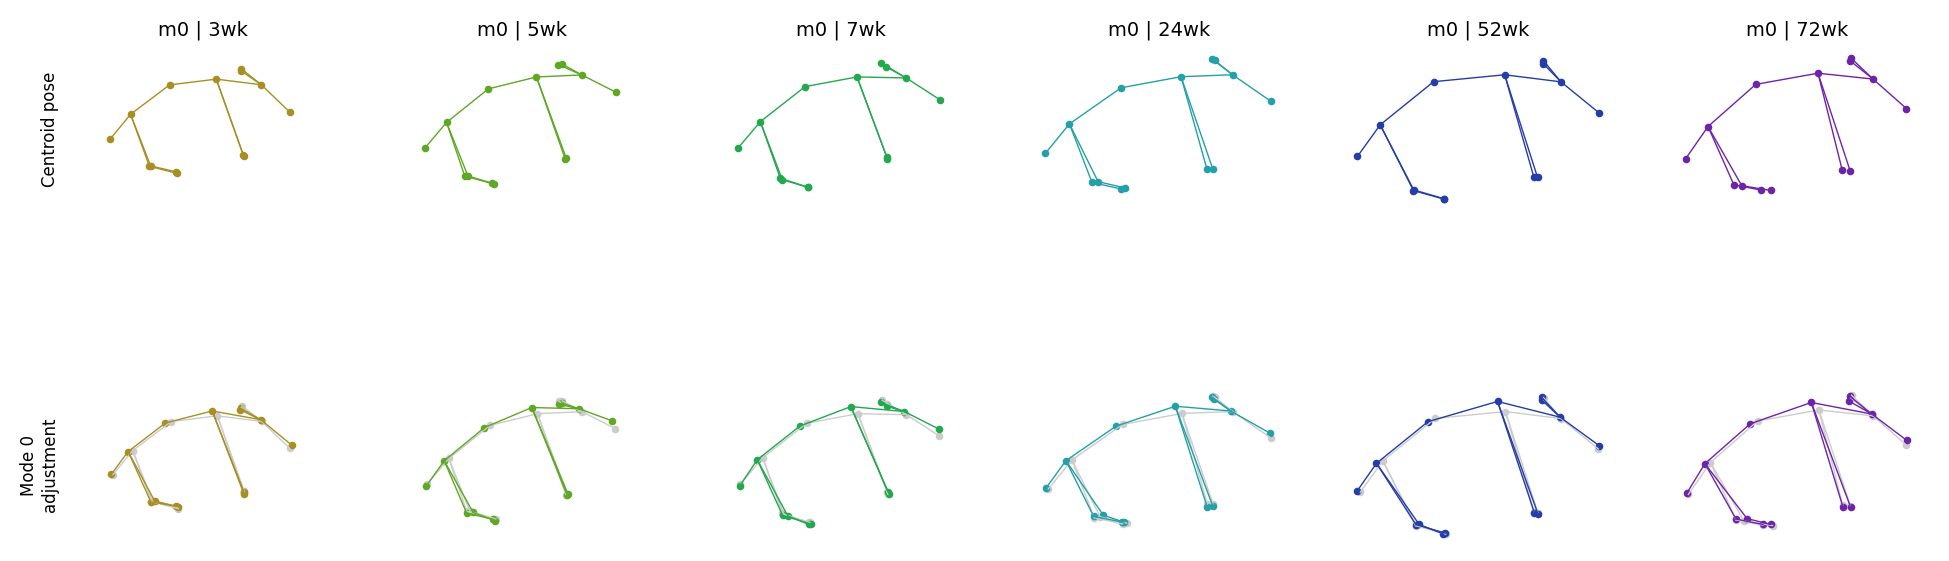

In [ ]:
plot_subset = [age_group[0] for age_group in age_groups]
xaxis, yaxis = 0, 2

viz.affine_mode.mode_body_diagrams(
    fit_params.morph,
    viz.affine_mode.mode_quantiles(fit_params.morph, all_poses, 0.9),
    metadata['age'], metadata['id'],
    xaxis, yaxis, plot_subset, age_pal);

Reference: m4 | 5wk


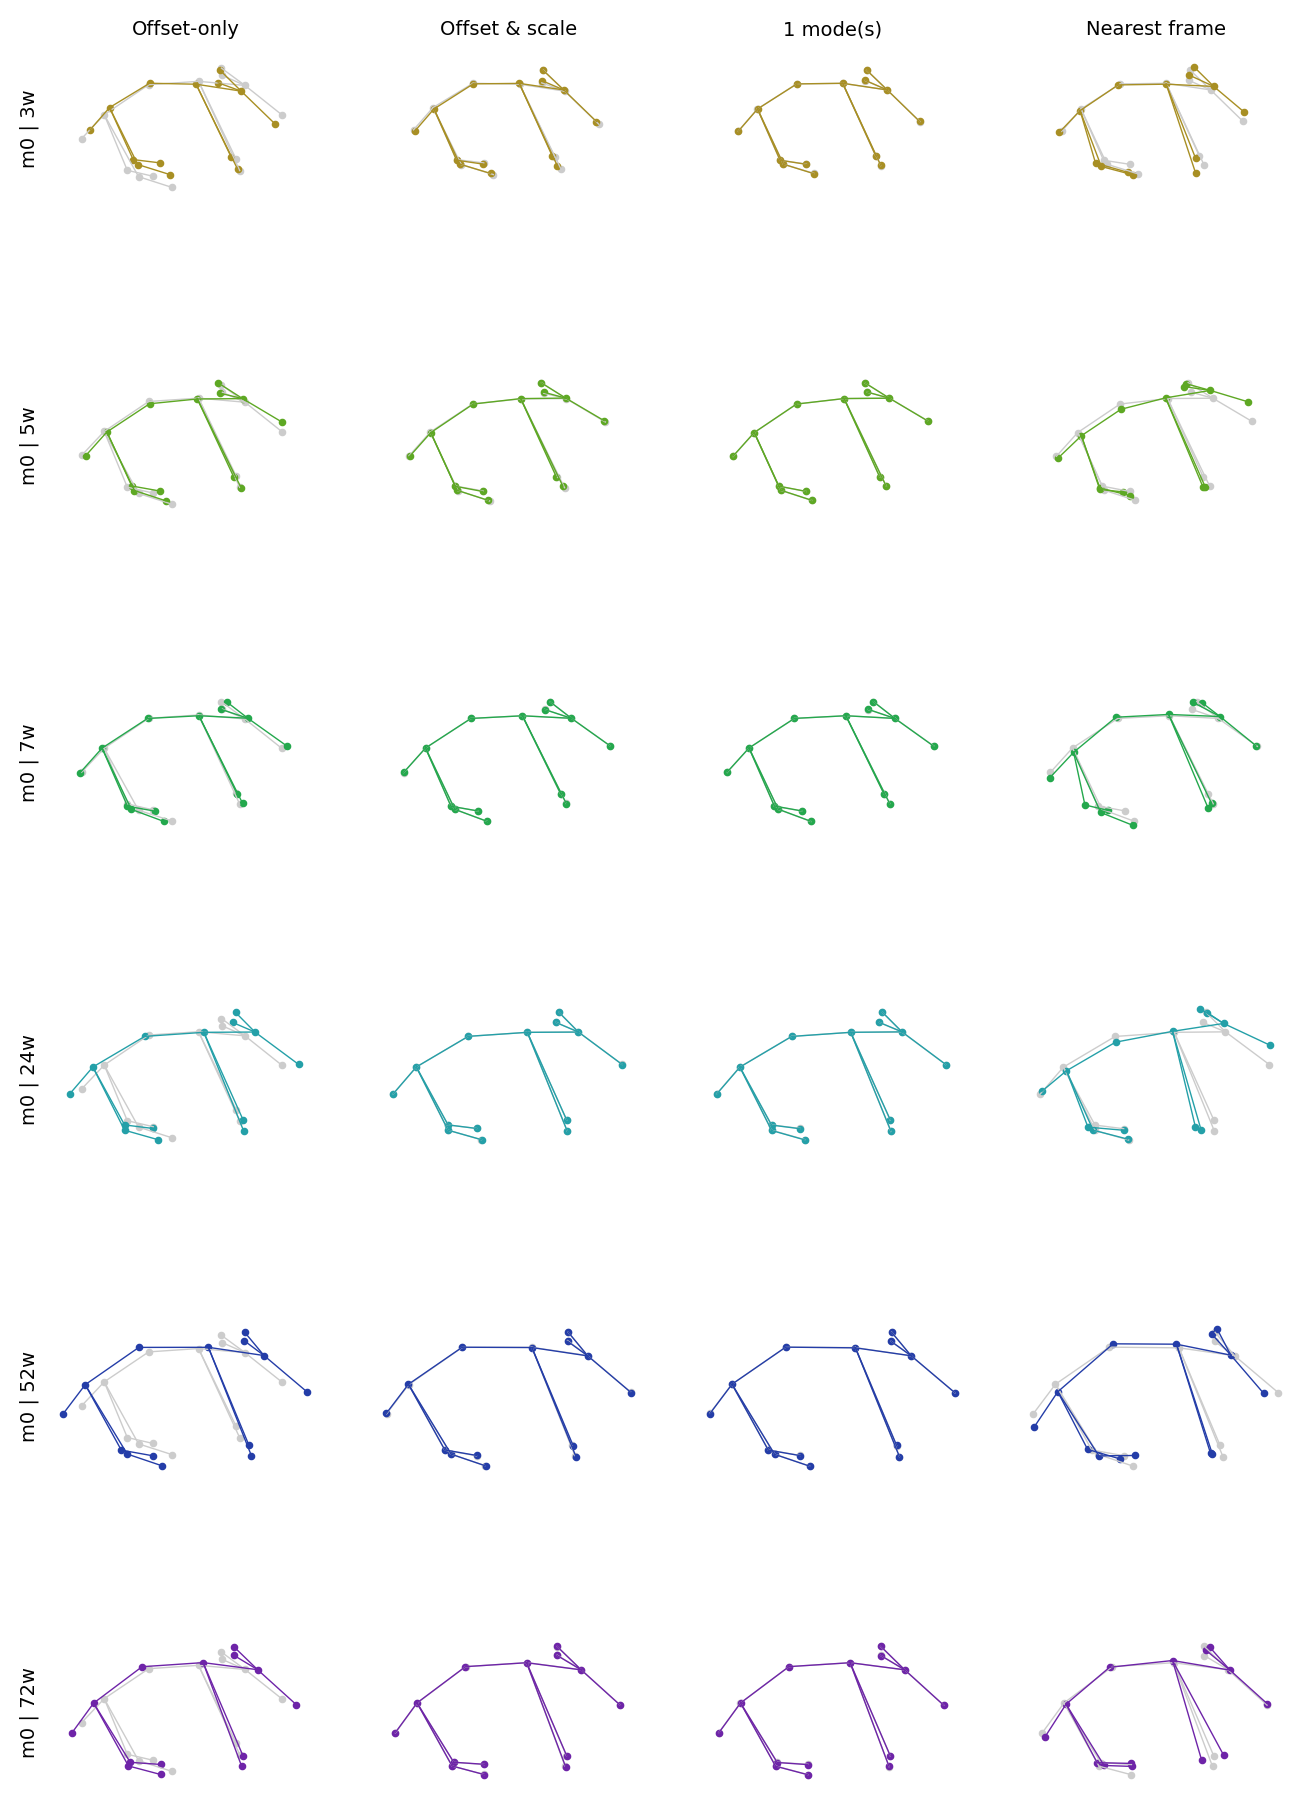

In [62]:
plot_ref_frame = 38950
plot_compare_subset = [age_group[0] for age_group in age_groups]
xaxis, yaxis = 0, 2

n_rows = len(plot_compare_subset)
n_cols = hyperparams.morph.L + 3
fig, ax = plt.subplots(
    n_rows, n_cols,
    sharex = True, sharey = True,
    figsize = (2 * n_cols, 2 * n_rows))

ref_frame_kpts = gt_obs.keypts[plot_ref_frame]
ref_subj_id = gt_obs.subject_ids[plot_ref_frame]
print(f"Reference: m{metadata['id'][ref_subj_id]} | {metadata['age'][ref_subj_id]}wk")
ref_frame_pose = model.morph.pose_mle_from_array(
    fit_params.morph, [ref_frame_kpts], [ref_subj_id])

unstacked_kpts = gt_obs.unstack(gt_obs.keypts)

ref_diagram_plot = lambda kpts, ax: viz.diagram_plots.plot_mouse(
    keypt_frame = kpts.reshape(14, 3), ax = ax,
    xaxis = xaxis, yaxis = yaxis,  **ref_diagram_kws)
age_diagram_plot = lambda kpts, ax, age: viz.diagram_plots.plot_mouse(
    keypt_frame = kpts.reshape(14, 3), ax = ax,
    xaxis = xaxis, yaxis = yaxis,  **age_diagram_kws[age])

for i_subj, subj_id in enumerate(plot_compare_subset):
    subj_age = metadata['age'][subj_id]
    color = age_pal[metadata['age'][subj_id]]

    # offset only
    offset_params = afm.as_offset_only(fit_params.morph)
    offset_kpts = model.morph.transform(
        offset_params, ref_frame_pose, subj_id
        ).reshape(14, 3)
    ref_diagram_plot(ref_frame_kpts.reshape(14, 3), ax[i_subj, 0])
    age_diagram_plot(offset_kpts, ax[i_subj, 0], subj_age)
    ref_diagram_plot(offset_kpts, ax[i_subj, 1])

    # offset & scale
    scale_params = afm.as_uniform_scale(fit_params.morph)
    scale_kpts = model.morph.transform(
        scale_params, ref_frame_pose, subj_id
        ).reshape(14, 3)
    age_diagram_plot(scale_kpts, ax[i_subj, 1], subj_age)
    ref_diagram_plot(scale_kpts, ax[i_subj, 2])

    # building up number of modes
    for l in range(1, hyperparams.morph.L+1):
        limited_mode_params = afm.with_sliced_modes(
            fit_params.morph, slice(0, l))
        curr_kpts = model.morph.transform(
                limited_mode_params,
                ref_frame_pose, subj_id)
        age_diagram_plot(curr_kpts.reshape(14, 3), ax[i_subj, l+1], subj_age)
        ref_diagram_plot(curr_kpts.reshape(14, 3), ax[i_subj, l+2])

    # closest true set of keypoints to morphed
    closest_kpts = unstacked_kpts[subj_id][jnp.argmin(
          ((unstacked_kpts[subj_id] - curr_kpts) ** 2).mean(axis = 1)
        )]
    age_diagram_plot(closest_kpts, ax[i_subj, -1], subj_age)

    ax[i_subj, 0].set_ylabel(f"m{metadata['id'][subj_id]} | {metadata['age'][subj_id]}w", fontsize = 7)
    
ax[0, 0].set_title("Offset-only", fontsize = 7)
ax[0, 1].set_title("Offset & scale", fontsize = 7)
for l in range(hyperparams.morph.L): ax[0, l+2].set_title(f"{l+1} mode(s)", fontsize = 7)
ax[0, -1].set_title("Nearest frame", fontsize = 7)
for a in ax.ravel():
    a.set_xticks([]); a.set_yticks([])
sns.despine(left = True, bottom = True)

### Debugging `ptxas` 

Run in a session even where we got the `ptxas` error, still appear to be jitting on the GPU:

In [ ]:
from functools import partial

def jax_softmax(x: jnp.array) -> jnp.array:
    exp_x = jnp.exp(x - jnp.max(x))
    return exp_x / exp_x.sum(axis=0)

def g(x): return jax_softmax(x)

@jax.jit
def g_jit(x): return jax_softmax(x)

x = jnp.linspace(0, 1, 1000)
print('device:', x.device_buffer.device())
g(x);
g_jit(x);

print("jitted:")
%timeit g_jit(x).block_until_ready()

print("g:")
%timeit g(x)

jitted:
272 µs ± 15 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
g:
1.26 ms ± 74.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
